In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# debug cuda
#import os
#os.environ['NUMBA_ENABLE_CUDASIM'] = '1'

import numba
from numba import SmartArray, cuda, float32, int8, int32
from numba.cuda.random import create_xoroshiro128p_states as make_rng_states, xoroshiro128p_uniform_float32 as get_rng
import numpy as np
from IPython import display
from scipy.misc import imshow
from functools import partial
import math
from miniutils import progbar

In [2]:
from fl4mes import variations as v, transforms as t, runner

v.plot_variation(v.swirl())

np.random.seed(2)
t.plot_transform(t.Transform(), xrs=101, yrs=101)

<IPython.core.display.Javascript object>


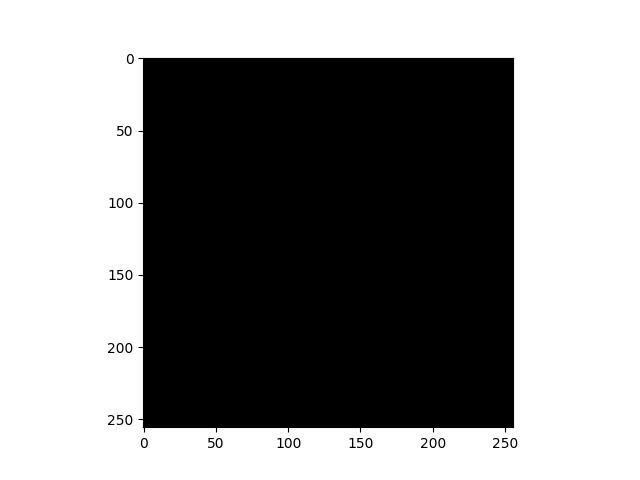

/home/scnerd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/scnerd/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


In [3]:
np.random.seed(0)
transforms = [t.Transform() for _ in range(10)]
# transforms[0].color = [1, 0, 0]
# transforms[1].color = [0, 1, 0]
# transforms[2].color = [0, 0, 1]
transition_matrix = np.random.normal(size=(10,10))
kernel, get_img = runner.make_kernel(16, transforms, transition_matrix, ((-10,10),(-10,10)), (256, 256), min_step=20)
kernel(256, 1)

for i in progbar(100):
    kernel(256, 20)
    
#     r, g, b, a = get_img()
#     from scipy import stats
#     print(stats.describe(r.ravel()))
#     print(stats.describe(g.ravel()))
#     print(stats.describe(b.ravel()))
#     print(stats.describe(a.ravel()))
#     print(np.stack([r,g,b,a], axis=-1))
#     r, g, b, a = runner.render(r, g, b, a)
    
plt.figure()
r, g, b, a = runner.render(*get_img())
im = np.stack([r,g,b], axis=-1)
im /= im.max()
#     print(im)
#print(im.shape)
plt.imshow(im, interpolation='nearest')
plt.show()
plt.gcf().canvas.draw()